Step 1.1: Load Data

In [19]:
from deepdow.benchmarks import OneOverN, Random
from deepdow.callbacks import EarlyStoppingCallback
from deepdow.data import InRAMDataset
from deepdow.data import RigidDataLoader
from deepdow.experiments import Run
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.nn import BachelierNet
from deepdow.utils import raw_to_Xy
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from pandas_ta import Imports

import pandas as pd
import torch
import yfinance as yf

# CREDIT TO DeepDow library
# This project utilizes DeepDow framework which provides and end-to-end Machine Learning based Portfloio Allocation. 
# Our primary focus is on feature engineering and tuning hyperparameters to show improvement of portfolio allocation using ML model.


In [20]:
# DEFINE EXPERIMENT PARAMETER (incl. Hyperparameters) HERE

tickers = ['GOOG','V','JNJ','T','DIS']
start = '2022-01-01'
end = '2023-12-31'

lookback, gap, horizon = 10, 1, 5

In [21]:

original = yf.download(tickers, start=start, end=end)
print('original', original.shape)

/opt/ha/capstone/env/lib/python3.9/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/ha/capstone/env/lib/python3.9/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  5 of 5 completed

original (501, 30)


Step 1.2: Add Features

In [50]:
features = {
    'RSI': [],
    # 'MACD_12_26_9': [],
    # 'MACDh_12_26_9': [],
    # 'MACDs_12_26_9': [],
    'BBL_5_2.0': [],
    'BBM_5_2.0': [],
    'BBU_5_2.0': [],
    'BBB_5_2.0': [],
    'BBP_5_2.0': [],
    # 'STOCHk_14_3_3': [],
    # 'STOCHd_14_3_3': [],
}
closes = original['Adj Close']
volumes = original['Volume']

print('closes', closes.shape)
print('volumes', volumes.shape)

for ticker in closes.columns:
    close = pd.DataFrame(closes[ticker])
    close.columns = ['close']
    rsi = close.ta.rsi()
    features['RSI'].append(rsi)

    # macd = close.ta.macd()
    # for c in macd.columns:
    #     features[c].append(macd[c])
    
    bbands = close.ta.bbands()
    for c in bbands.columns:
        features[c].append(bbands[c])
    
    # stoch = close.copy()
    # stoch['high'] = stoch['close'].rolling(lookback).max()
    # stoch['low'] = stoch['close'].rolling(lookback).min()
    # stoch.ta.stoch(append=True)

    # for c in ['STOCHk_14_3_3', 'STOCHd_14_3_3']:
    #     s = stoch[c]
    #     features[c].append(s)

raw_df = original.copy()

for k, v in features.items():
    features[k] = pd.concat(v, axis=1)
    features[k].columns = closes.columns
    for col in closes.columns:
        raw_df[(k, col)] = features[k][col]


closes (501, 5)
volumes (501, 5)


Step 2: Reformat Data

In [51]:
df = raw_df.swaplevel(0, 1, 1)
df = df.dropna(axis=0)

assert isinstance(df, pd.DataFrame)
assert isinstance(df.index, pd.DatetimeIndex)
assert isinstance(df.columns, pd.MultiIndex)

n_timesteps = len(df)
n_channels = len(df.columns.levels[1])
n_assets = len(df.columns.levels[0])

print('n_timesteps\t', n_timesteps)
print('n_assets\t', n_assets)
print('n_channels (features)\t', n_channels)
print('features', df.columns.levels[1])

n_timesteps	 487
n_assets	 5
n_channels (features)	 12
features Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI',
       'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0'],
      dtype='object', name='Price')


Step 3: Prepare X, y

In [52]:
print('- lookback \t', lookback)
print('- gap\t\t', gap)
print('- horizon \t', horizon)
X, timestamps, y, asset_names, indicators = raw_to_Xy(df, lookback=lookback,
                                                      gap=gap, freq="B", horizon=horizon)

print('X', X.shape)
print('y', y.shape)
print('asset_names', asset_names)
print('indicators', indicators)

dataset = InRAMDataset(X, y, timestamps=timestamps, asset_names=asset_names)

- lookback 	 5
- gap		 1
- horizon 	 4
X (495, 12, 5, 5)
y (495, 12, 4, 5)
asset_names ['DIS', 'GOOG', 'JNJ', 'T', 'V']
indicators ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0']


Step 4: Train Model

In [53]:
train_test_ratio = 0.8
n_samples = n_timesteps - lookback - horizon - gap + 1
split_ix = int(n_samples * 0.8)
train_ix = list(range(split_ix))
test_ix = list(range(split_ix + lookback + horizon, n_samples))

train_dataloader = RigidDataLoader(dataset, indices=train_ix, batch_size=32)
test_dataloader = RigidDataLoader(dataset, indices=test_ix, batch_size=32)

In [57]:
max_weight = 0.5
hidden_size = 32
network = BachelierNet(n_channels, n_assets, hidden_size=hidden_size, max_weight=max_weight)
loss = SharpeRatio(returns_channel=0)
benchmarks = {'1overN': OneOverN()}
metrics = {'drawdown': MaximumDrawdown(returns_channel=0)}


run = Run(network,
          loss,
          train_dataloader,
          val_dataloaders={'test': test_dataloader},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15)])

history = run.launch(n_epochs=20)

Epoch 19: 100%|██████████| 12/12 [00:05<00:00,  2.30it/s, loss=-0.02061, test_loss=-0.14173]


In [ ]:
per_epoch_results = history.metrics.groupby(
    ['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # double check number of samples each epoch
print(per_epoch_results.mean())  # mean loss per epoch

dataloader  metric  model    epoch
test        loss    network  0        87
Name: value, dtype: int64
dataloader  metric  model    epoch
test        loss    network  0       -0.127255
Name: value, dtype: float32


<Axes: xlabel='epoch'>

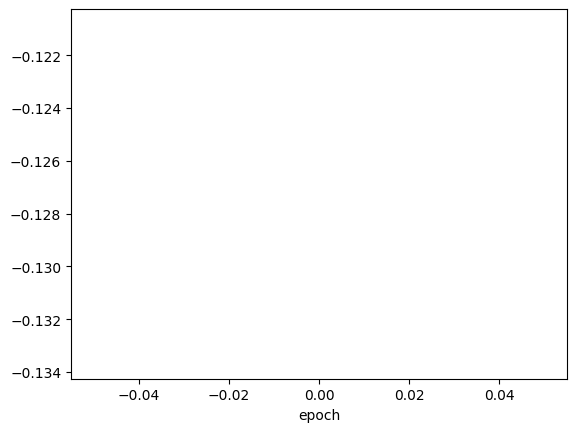

In [ ]:
per_epoch_results.mean()['test']['loss']['network'].plot()

array([<Axes: title={'center': 'MaxDD'}, xlabel='timestamp'>,
       <Axes: title={'center': 'Sharpe'}, xlabel='timestamp'>,
       <Axes: title={'center': 'MeanReturn'}, xlabel='timestamp'>],
      dtype=object)

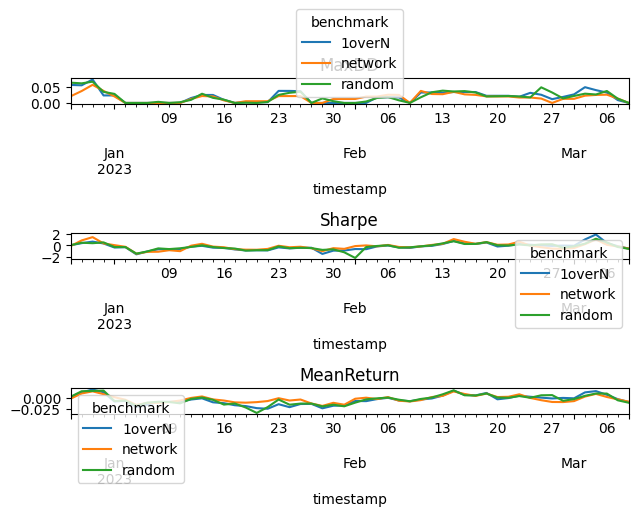

In [ ]:

benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'random': Random(),  # random allocation that is however close 1OverN
    'network': network
}
metrics = {
    'MaxDD': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
    'MeanReturn': MeanReturns()
}

metrics_table = generate_metrics_table(benchmarks,
                                       test_dataloader,
                                       metrics)
plot_metrics(metrics_table)

<Axes: >

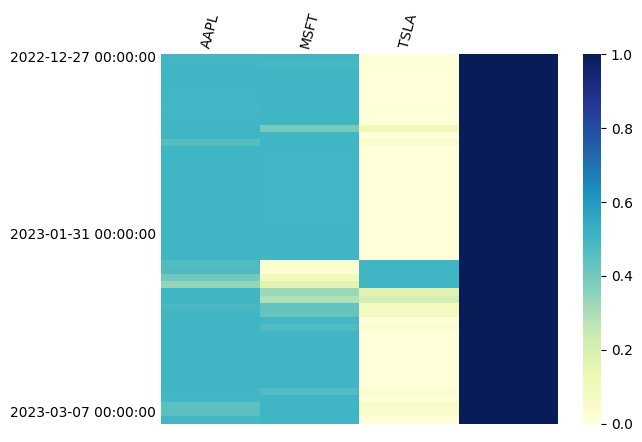

In [ ]:

weight_table = generate_weights_table(network, test_dataloader)

plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)